<a href="https://colab.research.google.com/github/dansojo/Medical_CV/blob/main/comparison_animal_musculoskeletal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import torch
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision import models
from torch.utils.data import Dataset

In [ ]:

# EfficientNetB0 정의
class EfficientNetB0Model(nn.Module):
    def __init__(self, num_classes=4):
        super(EfficientNetB0Model, self).__init__()
        # 사전 학습된 EfficientNet-B0 모델 로드
        self.model = models.efficientnet_b0(pretrained=True)

        # 마지막 분류 레이어를 수정하여 num_classes에 맞게 설정
        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.5),  # Dropout 추가 (과적합 방지)
            nn.Linear(in_features, num_classes)
        )


    def forward(self, x):
        return self.model(x)

# CheXNet (DenseNet-121) 모델 정의
class CheXNetModel(nn.Module):
    def __init__(self, num_classes=4):
        super(CheXNetModel, self).__init__()
        # DenseNet-121 기반 모델 초기화
        self.model = models.densenet121(pretrained=True)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.5),  # Dropout 추가 (과적합 방지)
            nn.Linear(in_features, num_classes)
        )


    def forward(self, x):
        return self.model(x)

# Vision Transformer (ViT) 정의
class ViTModel2(nn.Module):
    def __init__(self, num_classes=4):
        super(ViTModel2, self).__init__()
        # 사전 학습된 ViT 모델 로드
        self.model = models.vit_b_16(pretrained=True)

        # 마지막 레이어를 num_classes에 맞게 수정
        in_features = self.model.heads.head.in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.5),  # Dropout 추가 (과적합 방지)
            nn.Linear(in_features, num_classes)
        )


    def forward(self, x):
        return self.model(x)


In [ ]:
# GPU 또는 CPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 경로 정의
model_paths = {
    "EfficientNetB0": "/content/drive/MyDrive/Medical_CV/models/efficientnetb0_weights.pth",
    "CheXNet": "/content/drive/MyDrive/Medical_CV/models/chexnet_weights_V2.pth",
    "ViT": "/content/drive/MyDrive/Medical_CV/models/vit_weights_V2.pth",
}

# 클래스 수 정의
num_classes = 4

# 모델 초기화
efficientnet_model = EfficientNetB0Model(num_classes=num_classes).to(device)
chexnet_model = CheXNetModel(num_classes=num_classes).to(device)
vit_model = ViTModel2(num_classes=num_classes).to(device)

# 가중치 로드
efficientnet_weights = torch.load(model_paths["EfficientNetB0"], map_location=device)
chexnet_weights = torch.load(model_paths["CheXNet"], map_location=device)
vit_weights = torch.load(model_paths["ViT"], map_location=device)

# 각 모델에 가중치 적용
efficientnet_model.load_state_dict(efficientnet_weights)
chexnet_model.load_state_dict(chexnet_weights)
vit_model.load_state_dict(vit_weights)

# 평가 모드로 전환
efficientnet_model.eval()
chexnet_model.eval()
vit_model.eval()

print("모든 모델이 성공적으로 초기화되고 가중치가 로드되었습니다!")


<ipython-input-8-4936f170c4cf>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientnet_weights = torch.load(model_paths["EfficientNetB0"], map_location=device)
<ipyth

모든 모델이 성공적으로 초기화되고 가중치가 로드되었습니다!


In [ ]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.npy')]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):

        # 넘파이 파일 불러오기
        data = np.load(self.files[idx], allow_pickle=True).item()
        image_np, label = data['image'], data['label']

        # (1, H, W) 형식을 (3, H, W)로 변환
        if image_np.shape[0] == 1:  # 단일 채널인 경우
            image_np = np.repeat(image_np, 3, axis=0)  # 채널을 3번 반복하여 (3, H, W)로 확장

        # ToTensor 변환 적용
        image_tensor = torch.tensor(image_np, dtype=torch.float32)

        # (H, W, 3) -> (3, H, W)로 변환 필요 시 permute 사용
        if image_tensor.shape[0] != 3:
            image_tensor = image_tensor.permute(2, 0, 1)

        # Transform이 설정되어 있는 경우 적용
        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Transform 설정
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 모델 입력 크기에 맞춰 리사이즈
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
])

# 테스트 데이터 로드
test_dir = "/content/drive/MyDrive/Medical_CV/3/전처리_데이터/test"
test_dataset = TestDataset(root_dir=test_dir, transform=test_transform)

# DataLoader 생성
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 샘플 확인
for batch_idx, (images, labels) in enumerate(test_loader):
    print(f"Batch {batch_idx}: Images shape: {images.shape}, Labels shape: {labels.shape}")
    break


Batch 0: Images shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])


In [ ]:
# test_loader에서 샘플 배치 가져오기
data_iter = iter(test_loader)
images, labels = next(data_iter)

print(f"Image Batch Shape: {images.shape}")  # 이미지 텐서의 배치 크기
print(f"Label Batch Shape: {labels.shape}")  # 레이블 텐서의 배치 크기
print(f"Sample Labels: {labels}")           # 레이블 값 출력


Image Batch Shape: torch.Size([32, 3, 224, 224])
Label Batch Shape: torch.Size([32])
Sample Labels: tensor([1, 1, 0, 2, 0, 1, 1, 1, 2, 1, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 2, 0, 2, 1, 1, 1])


In [ ]:
from collections import Counter

# 전체 데이터셋 크기 확인
print(f"Total number of test samples: {len(test_loader.dataset)}")

# 클래스별 샘플 수 확인
all_labels = []
for _, labels in test_loader:
    all_labels.extend(labels.numpy())

label_counts = Counter(all_labels)
print(f"Class distribution in test set: {label_counts}")


Total number of test samples: 652
Class distribution in test set: Counter({1: 399, 0: 174, 2: 65, 3: 14})


**모델과 가중치 경로 딕셔너리 정의**

In [ ]:
model_dict = {
    "EfficientNetB0": efficientnet_model,
    "CheXNet": chexnet_model,
    "ViT": vit_model,
}

**1.  Accuracy (정확도)**

In [ ]:
from sklearn.metrics import accuracy_score

# Accuracy 측정 함수 정의
def evaluate_accuracy(model, test_loader, device):
    model.eval()  # 모델을 평가 모드로 전환
    all_preds = []
    all_labels = []

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # 예측값 추출
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy 계산
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# 모델별 Accuracy 계산 및 출력
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
accuracies = {}

for model_name, model in model_dict.items():
    print(f"Evaluating accuracy for {model_name}...")
    accuracy = evaluate_accuracy(model, test_loader, device)
    accuracies[model_name] = accuracy
    print(f"{model_name} Accuracy: {accuracy:.4f}%")

# 결과 출력
print("\nModel Accuracy Results:")
for model_name, accuracy in accuracies.items():
    print(f"{model_name}: {accuracy:.4f}")


Evaluating accuracy for EfficientNetB0...
EfficientNetB0 Accuracy: 0.3021%
Evaluating accuracy for CheXNet...
CheXNet Accuracy: 0.9954%
Evaluating accuracy for ViT...
ViT Accuracy: 0.9463%

Model Accuracy Results:
EfficientNetB0: 0.3021
CheXNet: 0.9954
ViT: 0.9463


In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import traceback

def evaluate_model_metrics(model, test_loader, device, valid_classes):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Filter valid classes
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    valid_indices = np.isin(all_labels, valid_classes) & np.isin(all_preds, valid_classes)

    filtered_preds = all_preds[valid_indices]
    filtered_labels = all_labels[valid_indices]

    # Calculate overall metrics
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Detailed classification report
    class_report = classification_report(
        filtered_labels,
        filtered_preds,
        target_names=[f"Class {i}" for i in valid_classes],
        zero_division=0
    )
    print("\nClassification Report:")
    print(class_report)

    # # Detailed classification report
    # num_classes = 4
    # class_report = classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(num_classes)], zero_division=0)
    # print("\nClassification Report:")
    # print(class_report)


In [ ]:

# Define valid classes
valid_classes = [0, 1, 2, 3]

for model_name, model in model_dict.items():
    try:
        print(f"Evaluating {model_name}...")
        results = evaluate_model_metrics(model, test_loader, device, valid_classes)
    except Exception as e:
        print(f"Error while evaluating {model_name}: {e}")
        traceback.print_exc()


Evaluating EfficientNetB0...
Accuracy: 0.3021
Precision: 0.4331
Recall: 0.3021
F1 Score: 0.2597

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.27      0.76      0.40       174
     Class 1       0.56      0.14      0.23       399
     Class 2       0.06      0.05      0.05        65
     Class 3       0.45      0.36      0.40        14

    accuracy                           0.30       652
   macro avg       0.34      0.33      0.27       652
weighted avg       0.43      0.30      0.26       652

Evaluating CheXNet...
Accuracy: 0.9954
Precision: 0.9955
Recall: 0.9954
F1 Score: 0.9954

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      1.00      0.99       174
     Class 1       1.00      0.99      1.00       399
     Class 2       0.98      1.00      0.99        65
     Class 3       1.00      0.93      0.96        14

    accuracy                           1.00       652
   mac

Confusion Matrix 생성 및 시각화

EfficientNetB0 Confusion Matrix:


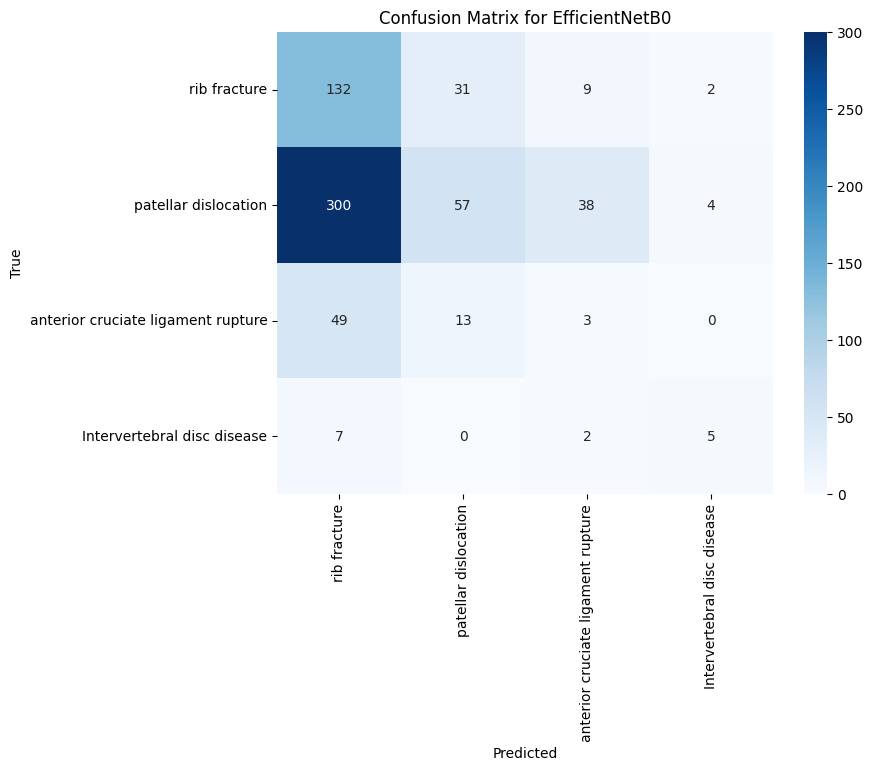

Confusion Matrix for EfficientNetB0:
 [[132  31   9   2]
 [300  57  38   4]
 [ 49  13   3   0]
 [  7   0   2   5]]
CheXNet Confusion Matrix:


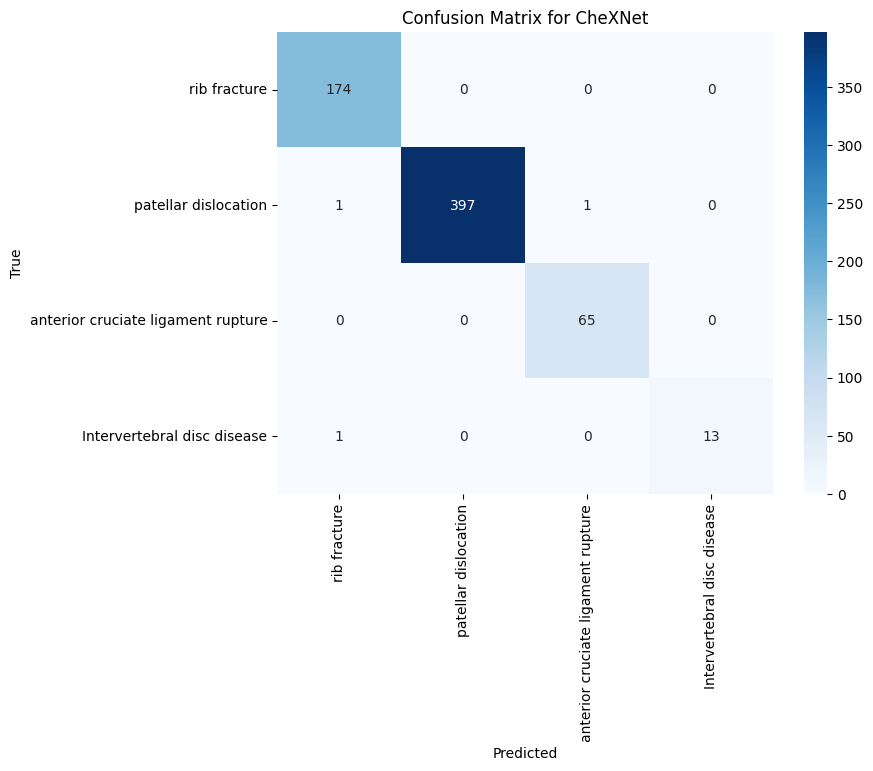

Confusion Matrix for CheXNet:
 [[174   0   0   0]
 [  1 397   1   0]
 [  0   0  65   0]
 [  1   0   0  13]]
ViT Confusion Matrix:


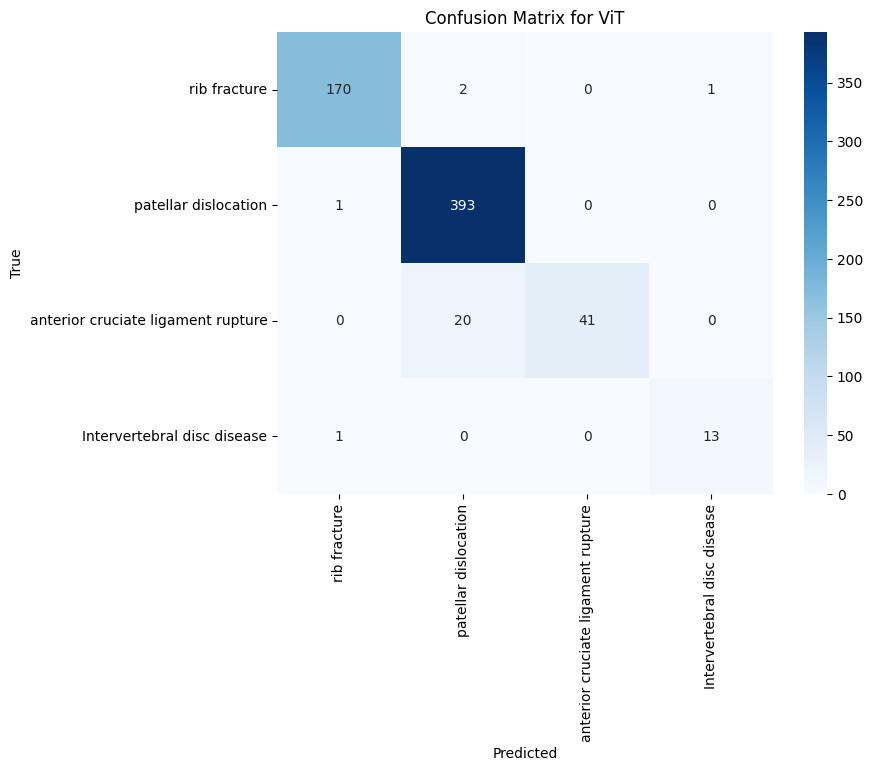

Confusion Matrix for ViT:
 [[170   2   0   1]
 [  1 393   0   0]
 [  0  20  41   0]
 [  1   0   0  13]]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = [
    "rib fracture",  # Class 0
    "patellar dislocation",  # Class 1
    "anterior cruciate ligament rupture",  # Class 2
    "Intervertebral disc disease"   # Class 3
]

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # 가장 높은 값을 가진 클래스 예측
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Confusion Matrix 시각화 함수
def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    # 허용된 클래스 (0, 1, 2, 3)으로 필터링
    valid_classes = [0, 1, 2, 3]
    valid_indices = [i for i, label in enumerate(y_true) if label in valid_classes and y_pred[i] in valid_classes]
    filtered_y_true = y_true[valid_indices]
    filtered_y_pred = y_pred[valid_indices]

    # 혼동 행렬 생성
    cm = confusion_matrix(filtered_y_true, filtered_y_pred, labels=valid_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return cm


# Confusion Matrix 생성 및 시각화 실행
for model_name, model in model_dict.items():
    y_true, y_pred = evaluate_model(model, test_loader, device)
    print(f"{model_name} Confusion Matrix:")
    cm = plot_confusion_matrix(y_true, y_pred, class_names, model_name)

    # 혼동 행렬을 통해 추가적인 통계 출력 (예: 클래스별 Precision, Recall)
    print(f"Confusion Matrix for {model_name}:\n", cm)


In [ ]:
import numpy as np

print("Unique classes in y_true:", np.unique(y_true))
print("Unique classes in y_pred:", np.unique(y_pred))

Unique classes in y_true: [0 1 2 3]
Unique classes in y_pred: [  0   1   2   3 126 313 622 684 784 917]


 ROC-AUC Curve 및 Precision-Recall Curve

EfficientNetB0 ROC-AUC and Precision-Recall Curve:


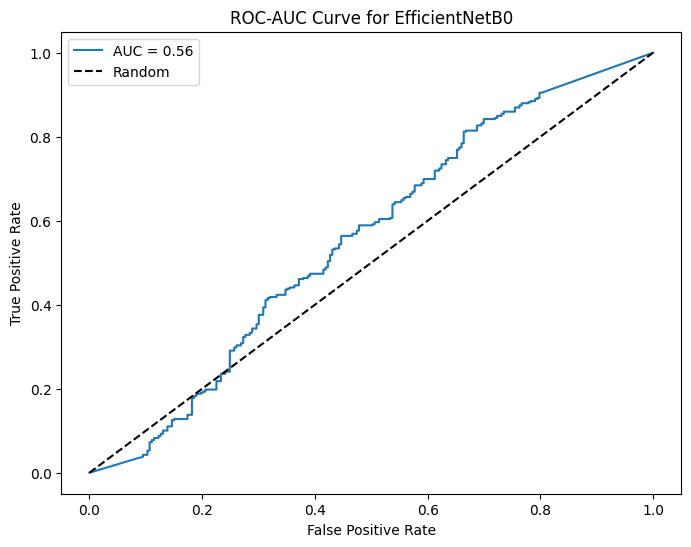

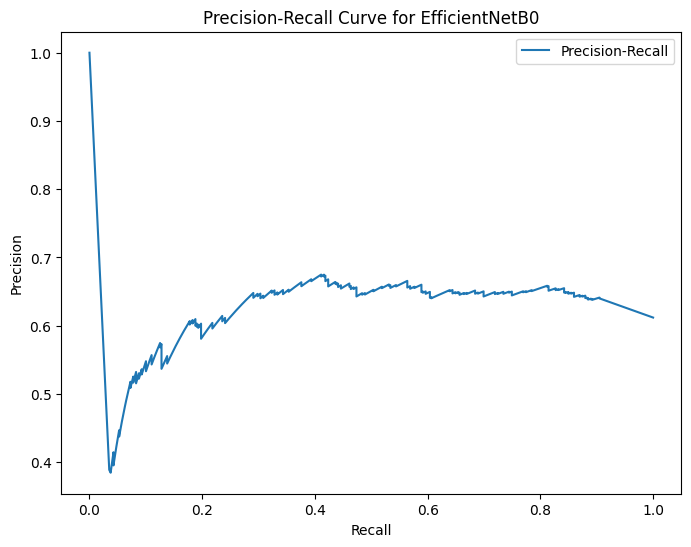

CheXNet ROC-AUC and Precision-Recall Curve:


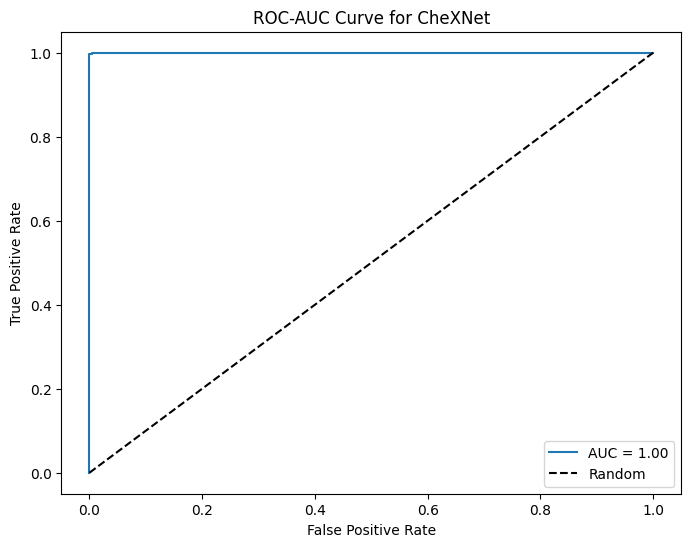

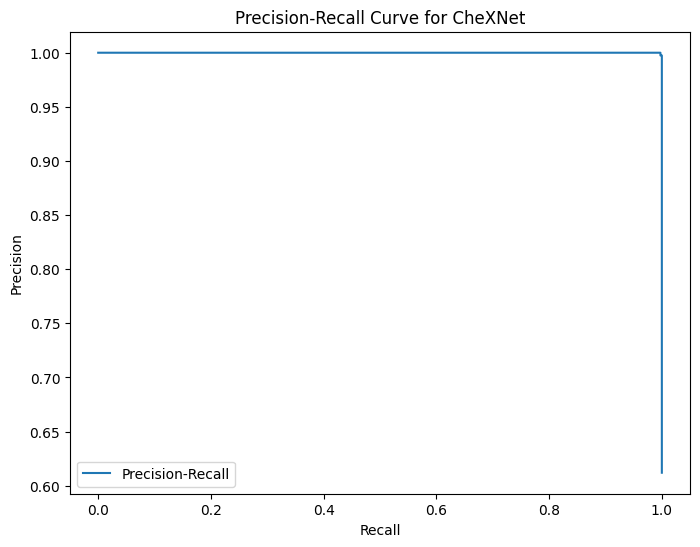

ViT ROC-AUC and Precision-Recall Curve:


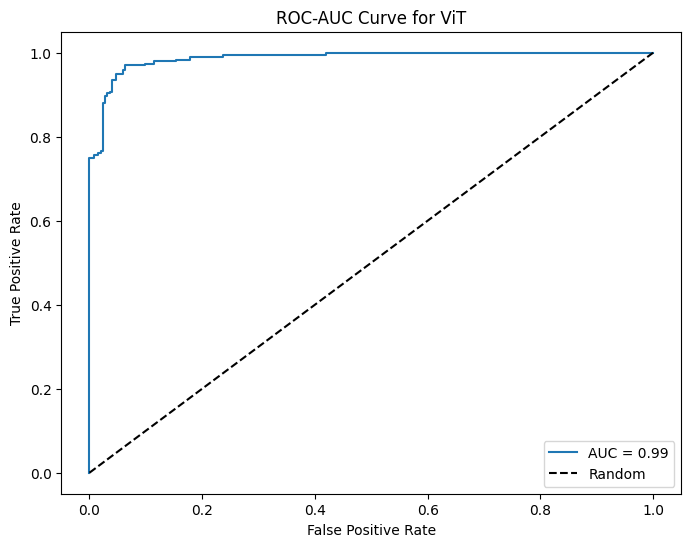

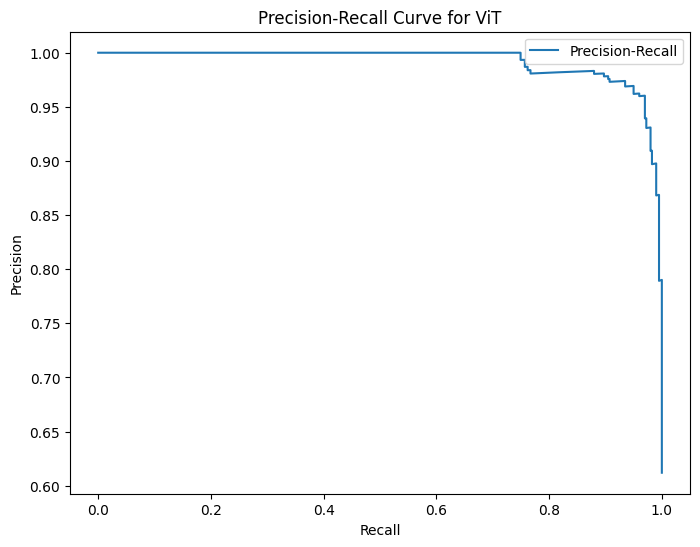

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def evaluate_model_probabilities(model, test_loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)  # 로짓을 확률로 변환
            all_probs.extend(probabilities.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, np.array(all_probs)

# ROC-AUC Curve 시각화 함수
def plot_roc_auc(y_true, y_pred_probs, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.title(f"ROC-AUC Curve for {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

# Precision-Recall Curve 시각화 함수
def plot_precision_recall(y_true, y_pred_probs, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs[:, 1], pos_label=1)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"Precision-Recall")
    plt.title(f"Precision-Recall Curve for {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

# ROC-AUC 및 Precision-Recall Curve 실행
for model_name, model in model_dict.items():
    y_true, y_pred_probs = evaluate_model_probabilities(model, test_loader, device)
    print(f"{model_name} ROC-AUC and Precision-Recall Curve:")
    plot_roc_auc(y_true, y_pred_probs, model_name)
    plot_precision_recall(y_true, y_pred_probs, model_name)

추론 시간 측정

In [ ]:
import time

# 모델 추론 시간 측정 함수
def measure_inference_time(model, test_loader, device):
    model.eval()
    model.to(device)
    start_time = time.time()

    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            _ = model(inputs)  # Forward pass

    total_time = time.time() - start_time
    return total_time

# 모델별 추론 시간 측정
inference_times = {}
for model_name, model in model_dict.items():
    inference_time = measure_inference_time(model, test_loader, device)
    inference_times[model_name] = inference_time
    print(f"{model_name} Inference Time: {inference_time:.2f} seconds")


EfficientNetB0 Inference Time: 2.72 seconds
CheXNet Inference Time: 2.88 seconds
ViT Inference Time: 7.66 seconds
